In [1]:
import ray
from ray.rllib import agents
from ray import tune
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.tf.fcnet_v2 import FullyConnectedNetwork
from ray.rllib.models import ModelCatalog
from ray.rllib.utils import try_import_tf
import gym
from gym import spaces
import or_gym
from or_gym.utils.env_config import *
from or_gym.algos.rl_utils import create_env
import numpy as np
import time
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline
ray.init(ignore_reinit_error=True)
tf = try_import_tf()

2020-05-08 13:50:15,321	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-05-08 13:50:15,323	INFO resource_spec.py:216 -- Starting Ray with 5.13 GiB memory available for workers and up to 2.58 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


In [2]:
def test_env(trainer, n_episodes, print_output=True):
    rewards, eps, eps_total = [], [], []
    training_results = []
    training = True
    batch = 0
    env = trainer.env_creator(trainer.config)
    s = env.reset()
    t_start = time.time()
    while training:
        t_batch = time.time()
        results = trainer.train()
        training_results.append(results)
        rewards.append(results['episode_reward_mean'])
        eps.append(results['episodes_this_iter'])
        eps_total.append(results['episodes_total'])
        batch += 1
        t_end = time.time()
        # Check for nan
        out = trainer.compute_action(s)
        if any(np.isnan([out]).flatten()):
            raise ValueError('NaN found in output')
        if sum(eps) >= n_episodes:
            training = False
            break
        if batch % 10 == 0 and print_output:
            t = t_end - t_batch
            t_tot = t_end - t_start
            print("\rEpisode: {}\tMean Rewards: {:.1f}\tEpisodes/sec: {:.2f}\tTotal Time: {:.1f}s".format(
                eps_total[-1], rewards[-1], eps[-1]/t, t_tot), end="")
            
    print("\nTotal Training Time: {:.1f}s\t".format(t_end - t_start))
    return trainer, training_results

In [3]:
class SCSchedMaskModel1(TFModelV2):
    
    def __init__(self, obs_space, action_space, num_outputs,
        model_config, name, true_obs_shape=(9,), action_embed_size=3,
        *args, **kwargs):
        super(SCSchedMaskModel1, self).__init__(obs_space,
            action_space, num_outputs, model_config, name, *args, **kwargs)
        self.action_embed_model = FullyConnectedNetwork(
            spaces.Box(0, 100, shape=true_obs_shape), action_space, action_embed_size,
            model_config, name + "_action_embedding")
        self.register_variables(self.action_embed_model.variables())
        
    def forward(self, input_dict, state, seq_lens):
        avail_actions = input_dict["obs"]["avail_actions"]
        action_mask = input_dict["obs"]["action_mask"]
        action_embedding, _ = self.action_embed_model({
            "obs": input_dict["obs"]["state"]
        })
        intent_vector = tf.expand_dims(action_embedding, 1)
        action_logits = tf.reduce_sum(avail_actions * intent_vector, axis=1)
        inf_mask = tf.maximum(tf.log(action_mask), tf.float32.min)
        return action_logits + inf_mask, state
    
    def value_function(self):
        return self.action_embed_model.value_function()

In [4]:
env_name = 'SCSched-v0'
config = agents.a3c.DEFAULT_CONFIG
config['model']['fcnet_hiddens'] = [128, 128]
config['model']['vf_share_layers'] = False
config['timesteps_per_iteration'] = 1000
n_episodes = 10000
trainer0 = agents.a3c.A3CTrainer(env=create_env(env_name), config=config)
trainer0, results0 = test_env(trainer0, n_episodes)

2020-05-08 13:50:15,925	INFO trainer.py:371 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-05-08 13:50:15,965	INFO trainer.py:512 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-05-08 13:51:00,044	INFO trainable.py:102 -- _setup took 44.086 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-05-08 13:51:00,045	WARNING util.py:45 -- Install gputil for GPU system monitoring.


Episode: 6417	Mean Rewards: -755.1	Episodes/sec: 114.60	Total Time: 54.2s
Total Training Time: 88.0s	


In [5]:
# Add masking via custom model
ModelCatalog.register_custom_model('masked_sched_model', SCSchedMaskModel1)
config_mask = deepcopy(config)
config_mask['model']['custom_model'] = 'masked_sched_model'
env_name = 'SCSched-v1'
trainer1 = agents.a3c.A3CTrainer(env=create_env(env_name), config=config_mask)
trainer1, results1 = test_env(trainer1, n_episodes)

2020-05-08 13:52:28,652	WARNING util.py:45 -- Install gputil for GPU system monitoring.


Episode: 5713	Mean Rewards: -818.9	Episodes/sec: 103.75	Total Time: 54.0s
Total Training Time: 91.6s	


In [6]:
env_name = 'SCSched-v2'
trainer2 = agents.a3c.A3CTrainer(env=create_env(env_name), config=config)
trainer2, results2 = test_env(trainer2, n_episodes)

2020-05-08 13:54:00,978	WARNING util.py:45 -- Install gputil for GPU system monitoring.


Episode: 5513	Mean Rewards: -643.2	Episodes/sec: 101.02	Total Time: 54.4s
Total Training Time: 97.6s	


In [33]:
class SCSchedMaskModel2(TFModelV2):
    
    def __init__(self, obs_space, action_space, num_outputs,
        model_config, name, true_obs_shape=(9,), action_embed_size=3,
        *args, **kwargs):
        super(SCSchedMaskModel2, self).__init__(obs_space,
            action_space, num_outputs, model_config, name, *args, **kwargs)
        self.action_embed_model = FullyConnectedNetwork(
            spaces.Box(0, 100, shape=true_obs_shape), action_space, action_embed_size,
            model_config, name + "_action_embedding")
        self.register_variables(self.action_embed_model.variables())
        
    def forward(self, input_dict, state, seq_lens):
        avail_actions = input_dict["obs"]["avail_actions"]
        action_mask = input_dict["obs"]["action_mask"]
        action_embedding, _ = self.action_embed_model({
            "obs": input_dict["obs"]["state"]
        })
        intent_vector = tf.expand_dims(action_embedding, 1)
        action_logits = tf.reduce_sum(action_mask * intent_vector, axis=1)
        return action_logits, state
    
    def value_function(self):
        return self.action_embed_model.value_function()

In [34]:
ModelCatalog.register_custom_model('masked_cont_model', SCSchedMaskModel2)
env_name = 'SCSched-v3'
config_mask_cont = deepcopy(config)
config_mask_cont['model']['custom_model'] = 'masked_cont_model'
trainer3 = agents.a3c.A3CTrainer(env=create_env(env_name), config=config_mask_cont)
# trainer3, results3 = test_env(trainer3, n_episodes)

ValueError: Dimensions must be equal, but are 3 and 6 for 'default_policy/mul' (op: 'Mul') with input shapes: [?,3], [?,1,6].

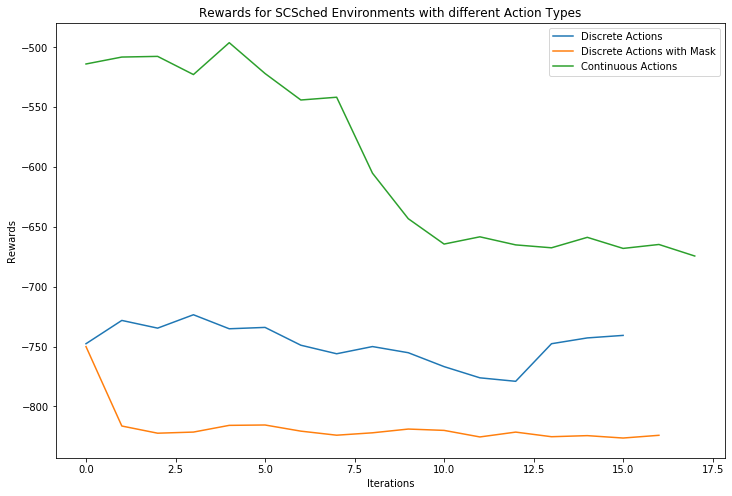

In [7]:
rewards0 = [i['episode_reward_mean'] for i in results0]
rewards1 = [i['episode_reward_mean'] for i in results1]
rewards2 = [i['episode_reward_mean'] for i in results2]
# rewards3 = [i['episode_reward_mean'] for i in results3]

plt.figure(figsize=(12,8))
plt.plot(rewards0, label='Discrete Actions')
plt.plot(rewards1, label='Discrete Actions with Mask')
plt.plot(rewards2, label='Continuous Actions')
# plt.plot(rewards3, label='Continuous Actions with Mask')
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Rewards for SCSched Environments with different Action Types')
plt.legend()
plt.show()

In [22]:
env0 = trainer0.env_creator(config)
env1 = trainer1.env_creator(config_mask)
s = env1.reset()
s_ = s['state']
print("State: {}".format(s))

mask = s['action_mask']
if any(mask==0):
    print('\nMasked action(s): {}'.format(np.where(mask==0)[0]))
else:
    print('\nNo masking')

print("Trainer 0 Output: {}".format(trainer0.compute_action(s_)))

print("Trainer 1 Output: {}".format(trainer1.compute_action(s)))

env2 = trainer2.env_creator(config)
print("Trainer 2 Output: {}".format(trainer2.compute_action(s_)))

# env3 = trainer3.env_creator(config_mask)
# print("Trainer 3 Output: {}".format(trainer3.compute_action(s)))

State: {'action_mask': array([0, 1, 1]), 'avail_actions': array([1., 1., 1.]), 'state': array([ 0.,  1., 10.,  0.,  0.,  0.,  5.,  0.,  0.])}

Masked action(s): [0]
Trainer 0 Output: 2
Trainer 1 Output: 1
Trainer 2 Output: [0. 0. 1.]


In [54]:
actions, rewards, prod_selection = [], [], []
mask_fail = 0
for i in range(100):
    done = False
    s = env3.reset()
    reward = 0
    while done == False:
#         last_action = int(s[env3.state_indices['prev_actions'][0]])
        last_action = int(s['state'][env1.state_indices['prev_actions'][0]])
        a = trainer3.compute_action(s)
        actions.append(a)
        # Invalid actions
        invalid_action = np.where(env3.transition_matrix[last_action]==0)[0]
        if len(invalid_action) > 0:
            try:
                prod = a
                if prod == invalid_action:
                    mask_fail += 1
            except ValueError:
                prod = np.argmax(a)
                if prod == invalid_action:
                    mask_fail += 1
        s, r, done, _ = env3.step(a)
        reward += r
        prod_selection.append(prod)
        if done:
            rewards.append(reward)
            
print(mask_fail)
# np.unique(actions)
np.unique(prod_selection)

248


array([0, 1, 2])

In [39]:
np.where(env1.transition_matrix[1]==0)[0]

array([0])

In [32]:
last_action = int(s['state'][env0.state_indices['prev_actions'][0]])

In [33]:
env0.transition_matrix[last_action]

array([0, 1, 1])

In [56]:
env = or_gym.make('SCSched-v3')

In [28]:
env0.demand.T

array([[5., 0., 0., 5., 0., 0., 5., 0., 0., 5., 0.],
       [0., 5., 0., 0., 5., 0., 0., 5., 0., 0., 0.],
       [0., 0., 5., 0., 0., 5., 0., 0., 5., 0., 0.]])